**Imports & Chargement config NB02**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path
from collections import Counter
import warnings
import pickle
import time
import copy
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score
)
import seaborn as sns
from PIL import Image
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [4]:
# ── Device ──────────
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device : {DEVICE}")
if DEVICE.type == 'cuda':
    print(f"   GPU    : {torch.cuda.get_device_name(0)}")
    print(f"   VRAM   : "
          f"{torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB")

# ── Chemins ───────
BASE_DIR = Path("/home/admin1/Documents/SN CNN_DEEP_LEARNING")
RESULTS  = BASE_DIR / "results"

🖥️  Device : cuda
   GPU    : NVIDIA GeForce RTX 4060 Laptop GPU
   VRAM   : 8.2 GB


In [5]:
CLASSES = sorted([
    "crease", "crescent_gap", "inclusion", "oil_spot",
    "punching_hole", "rolled_pit", "silk_spot",
    "waist folding", "water_spot", "welding_line"
])
CLASS2IDX   = {cls: idx for idx, cls in enumerate(CLASSES)}
NUM_CLASSES = len(CLASSES)

class SteelDefectDataset(Dataset):
    CLASSES   = CLASSES
    CLASS2IDX = CLASS2IDX

    def __init__(self, img_dir, label_dir=None, transform=None):
        self.img_dir   = Path(img_dir)
        self.transform = transform
        self.samples   = []
        self.labels    = []
        self._scan_dataset()

    def _scan_dataset(self):
        for class_name in self.CLASSES:
            class_dir = self.img_dir / class_name
            if not class_dir.exists():
                continue
            class_idx = self.CLASS2IDX[class_name]
            images = (
                list(class_dir.glob("*.jpg")) +
                list(class_dir.glob("*.JPG")) +
                list(class_dir.glob("*.jpeg")) +
                list(class_dir.glob("*.png")) +
                list(class_dir.glob("*.bmp"))
            )
            for img_path in sorted(images):
                self.samples.append((img_path, class_idx))
                self.labels.append(class_idx)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = np.array(Image.open(img_path).convert("RGB"))
        if self.transform:
            augmented = self.transform(image=image)
            image     = augmented["image"]
        return image, label


class TransformSubset(Dataset):
    """Applique un transform différent à un sous-ensemble"""
    def __init__(self, dataset, indices, transform):
        self.dataset   = dataset
        self.indices   = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_path, label = self.dataset.samples[self.indices[idx]]
        image = np.array(Image.open(img_path).convert("RGB"))
        if self.transform:
            augmented = self.transform(image=image)
            image     = augmented["image"]
        return image, label

    @property
    def labels(self):
        return [self.dataset.labels[i] for i in self.indices]

**CHARGEMENT DU PICKLE**

In [6]:
CFG_PATH = RESULTS / "preprocessing_config.pkl"

with open(CFG_PATH, "rb") as f:
    cfg = pickle.load(f)

# ── Récupération des variables ─────
MEAN         = cfg["MEAN"]
STD          = cfg["STD"]
IMG_SIZE     = cfg["IMG_SIZE"]
BATCH_SIZE   = cfg["BATCH_SIZE"]
NUM_WORKERS  = cfg["NUM_WORKERS"]
train_loader = cfg["train_loader"]
val_loader   = cfg["val_loader"]
train_dataset = cfg["train_dataset"]
val_dataset   = cfg["val_dataset"]

In [7]:
# ── Vérification ──
print("\n╔══════════════════════════════════════════╗")
print("║      CONFIG NB02 CHARGÉE ✅              ║")
print("╠══════════════════════════════════════════╣")
print(f"║  Classes     : {NUM_CLASSES:<26}║")
print(f"║  IMG_SIZE    : {IMG_SIZE:<26}║")
print(f"║  Train       : {len(train_dataset):<26}║")
print(f"║  Val         : {len(val_dataset):<26}║")
print(f"║  Train batch : {len(train_loader):<26}║")
print(f"║  Val batch   : {len(val_loader):<26}║")
print(f"║  Mean        : {[round(m,3) for m in MEAN]}     ║")
print(f"║  Std         : {[round(s,3) for s in STD]}     ║")
print("╠══════════════════════════════════════════╣")
print("║  Device      : "+ str(DEVICE) + " 🚀" +     " " * (23 - len(str(DEVICE)))+"║")
print("╚══════════════════════════════════════════╝")



╔══════════════════════════════════════════╗
║      CONFIG NB02 CHARGÉE ✅              ║
╠══════════════════════════════════════════╣
║  Classes     : 10                        ║
║  IMG_SIZE    : 224                       ║
║  Train       : 1844                      ║
║  Val         : 462                       ║
║  Train batch : 58                        ║
║  Val batch   : 15                        ║
║  Mean        : [0.331, 0.331, 0.331]     ║
║  Std         : [0.096, 0.096, 0.096]     ║
╠══════════════════════════════════════════╣
║  Device      : cuda 🚀                   ║
╚══════════════════════════════════════════╝


**Architecture CNN**

In [ ]:
#  CELLULE 2 — BUILD MODEL
#  EfficientNet-B0 (défaut) ou ResNet50

def build_model(backbone='efficientnet_b0', num_classes=NUM_CLASSES):
    """
    Construit un modèle pré-entraîné ImageNet
    avec une tête de classification custom

    Args:
        backbone    : 'efficientnet_b0' | 'resnet50'
        num_classes : nombre de classes (10)

    Returns:
        model prêt pour le fine-tuning
    """

    # ── Backbone pré-entraîné ────
    if backbone == 'efficientnet_b0':
        model = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
        )
        in_features = model.classifier[1].in_features

        # Tête custom
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.3),
            nn.Linear(512, num_classes)
        )

    elif backbone == 'resnet50':
        model = models.resnet50(
            weights=models.ResNet50_Weights.IMAGENET1K_V1
        )
        in_features = model.fc.in_features

        # Tête custom
        model.fc = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.3),
            nn.Linear(512, num_classes)
        )
    else:
        raise ValueError(f"Backbone inconnu : {backbone}. "
                         f"Choisir 'efficientnet_b0' ou 'resnet50'")
    return model

# ==============================
#  CELLULE 3 — FREEZE / UNFREEZE
# ==============================
def freeze_backbone(model, backbone):
    """Gèle tous les paramètres sauf la tête de classification"""
    if backbone == 'resnet50':
        for name, param in model.named_parameters():
            if 'fc' not in name:
                param.requires_grad = False

    elif backbone == 'efficientnet_b0':
        for name, param in model.named_parameters():
            if 'classifier' not in name:
                param.requires_grad = False


def unfreeze_backbone(model, backbone):
    """Dégèle tous les paramètres du modèle"""
    for param in model.parameters():
        param.requires_grad = True


def count_params(model):
    """Affiche le nombre de paramètres total / entraînables / gelés"""
    total     = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters()
                    if p.requires_grad)
    frozen    = total - trainable

    print("╔══════════════════════════════════════════╗")
    print("║        PARAMÈTRES DU MODÈLE              ║")
    print("╠══════════════════════════════════════════╣")
    print(f"║  Total      : {total:>12,}               ║")
    print(f"║  Trainables : {trainable:>12,}  ✅           ║")
    print(f"║  Gelés      : {frozen:>12,}  🔒           ║")
    print("╚══════════════════════════════════════════╝")


# ── Application immédiate 
freeze_backbone(model, BACKBONE)
count_params(model)

# ==============
#  INSTANCIATION
# ==============

BACKBONE = 'resnet50'   # ← change ici si tu veux resnet50 efficientnet_b0

model = build_model(backbone=BACKBONE, num_classes=NUM_CLASSES)
model = model.to(DEVICE)

# Phase 1 → backbone gelé
freeze_backbone(model, backbone=BACKBONE)

print(f"✅ Modèle : {BACKBONE}")
print(f"✅ Device : {DEVICE}\n")
count_params(model)


╔══════════════════════════════════════════╗
║        PARAMÈTRES DU MODÈLE              ║
╠══════════════════════════════════════════╣
║  Total      :   24,563,274               ║
║  Trainables :    1,055,242  ✅           ║
║  Gelés      :   23,508,032  🔒           ║
╚══════════════════════════════════════════╝
✅ Modèle : resnet50
✅ Device : cuda

╔══════════════════════════════════════════╗
║        PARAMÈTRES DU MODÈLE              ║
╠══════════════════════════════════════════╣
║  Total      :   24,563,274               ║
║  Trainables :    1,055,242  ✅           ║
║  Gelés      :   23,508,032  🔒           ║
╚══════════════════════════════════════════╝


**Fonctions Train & Eval**

In [9]:
def train_one_epoch(model, loader, optimizer, criterion, scaler):
    """
    Boucle d'entraînement avec Mixed Precision (AMP)
    Retourne : loss moyenne, accuracy
    """
    model.train()
    total_loss = 0.0
    correct    = 0
    total      = 0

    for batch_idx, (images, labels) in enumerate(loader):
        images = images.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)

        optimizer.zero_grad()

        # ── Mixed Precision ──────────────────────────
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images)
            loss    = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # ── Métriques ────────────────────────────────
        total_loss += loss.item() * images.size(0)
        preds       = outputs.argmax(dim=1)
        correct    += (preds == labels).sum().item()
        total      += images.size(0)

        # Progress bar légère
        if (batch_idx + 1) % 10 == 0:
            print(f"   Batch [{batch_idx+1:>3}/{len(loader)}] "
                  f"Loss: {loss.item():.4f}", end='\r')

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


@torch.no_grad()
def eval_one_epoch(model, loader, criterion):
    """
    Boucle de validation
    Retourne : loss moyenne, accuracy, preds, targets
    """
    model.eval()
    total_loss = 0.0
    correct    = 0
    total      = 0
    all_preds   = []
    all_targets = []

    for images, labels in loader:
        images = images.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)

        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images)
            loss    = criterion(outputs, labels)

        total_loss += loss.item() * images.size(0)
        preds       = outputs.argmax(dim=1)
        correct    += (preds == labels).sum().item()
        total      += images.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy, all_preds, all_targets

print("✅ Fonctions train/eval définies")


✅ Fonctions train/eval définies


**Entraînement Phase1**

In [20]:
# ── Hyperparamètres ────────────────────────────────────────
EPOCHS_P1  = 10
LR_P1      = 1e-3
BEST_PATH1 = RESULTS / "best_model_phase1.pth"

# ── Loss : pondérée si déséquilibre de classes ─────────────
class_counts  = Counter(train_dataset.labels)
class_weights = torch.tensor(
    [1.0 / class_counts[i] for i in range(NUM_CLASSES)],
    dtype=torch.float
).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# ── Optimizer Phase 1 ──────────────────────────────────────
optimizer_p1 = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR_P1,
    weight_decay=1e-4
)
scheduler_p1 = CosineAnnealingLR(
    optimizer_p1, T_max=EPOCHS_P1, eta_min=1e-5
)

# ── Mixed Precision ────────────────────────────────────────
scaler = torch.cuda.amp.GradScaler()

# ── Historique ─────────────────────────────────────────────
history_p1 = {
    'train_loss': [], 'train_acc': [],
    'val_loss'  : [], 'val_acc'  : []
}
best_val_acc_p1 = 0.0

# ── Fonctions train / eval ─────────────────────────────────
def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            loss    = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        preds         = outputs.argmax(dim=1)
        correct      += (preds == labels).sum().item()
        total        += imgs.size(0)

    return running_loss / total, correct / total


def eval_one_epoch(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_targets       = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss    = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            preds         = outputs.argmax(dim=1)
            correct      += (preds == labels).sum().item()
            total        += imgs.size(0)
            all_preds    .extend(preds.cpu().numpy())
            all_targets  .extend(labels.cpu().numpy())

    return (running_loss / total,
            correct / total,
            all_preds,
            all_targets)


# ── Boucle Phase 1 ─────────────────────────────────────────
print("╔══════════════════════════════════════════╗")
print("║   PHASE 1 — Tête de classification       ║")
print(f"║   Epochs : {EPOCHS_P1}  |  LR : {LR_P1}             ║")
print("╚══════════════════════════════════════════╝\n")

for epoch in range(1, EPOCHS_P1 + 1):
    t0 = time.time()

    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer_p1, criterion, scaler
    )
    val_loss, val_acc, _, _ = eval_one_epoch(
        model, val_loader, criterion
    )
    scheduler_p1.step()

    # ── Sauvegarde best ────────────────────────────────────
    if val_acc > best_val_acc_p1:
        best_val_acc_p1 = val_acc
        torch.save(model.state_dict(), BEST_PATH1)
        flag = "✅ BEST"
    else:
        flag = ""

    history_p1['train_loss'].append(train_loss)
    history_p1['train_acc'] .append(train_acc)
    history_p1['val_loss']  .append(val_loss)
    history_p1['val_acc']   .append(val_acc)

    elapsed = time.time() - t0
    print(f"Epoch [{epoch:>2}/{EPOCHS_P1}] "
          f"| Train Loss: {train_loss:.4f}  Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f}  Acc: {val_acc:.4f} "
          f"| {elapsed:.1f}s  {flag}")

print(f"\n🏆 Best Val Acc Phase 1 : {best_val_acc_p1:.4f}")


╔══════════════════════════════════════════╗
║   PHASE 1 — Tête de classification       ║
║   Epochs : 10  |  LR : 0.001            ║
╚══════════════════════════════════════════╝



Epoch [ 1/10] | Train Loss: 2.0053  Acc: 0.2148 | Val Loss: 1.6185  Acc: 0.3333 | 19.7s  ✅ BEST
Epoch [ 2/10] | Train Loss: 1.5555  Acc: 0.3270 | Val Loss: 1.3111  Acc: 0.3853 | 20.0s  ✅ BEST
Epoch [ 3/10] | Train Loss: 1.5431  Acc: 0.3286 | Val Loss: 1.2093  Acc: 0.4740 | 19.7s  ✅ BEST
Epoch [ 4/10] | Train Loss: 1.4737  Acc: 0.3384 | Val Loss: 1.2293  Acc: 0.4026 | 19.5s  
Epoch [ 5/10] | Train Loss: 1.3602  Acc: 0.3362 | Val Loss: 1.2388  Acc: 0.4177 | 20.1s  
Epoch [ 6/10] | Train Loss: 1.4068  Acc: 0.3362 | Val Loss: 1.1941  Acc: 0.4675 | 20.1s  
Epoch [ 7/10] | Train Loss: 1.3620  Acc: 0.3601 | Val Loss: 1.1374  Acc: 0.5065 | 19.7s  ✅ BEST
Epoch [ 8/10] | Train Loss: 1.2936  Acc: 0.3791 | Val Loss: 1.1048  Acc: 0.5130 | 20.1s  ✅ BEST
Epoch [ 9/10] | Train Loss: 1.3800  Acc: 0.3536 | Val Loss: 1.0918  Acc: 0.5173 | 19.7s  ✅ BEST
Epoch [10/10] | Train Loss: 1.3536  Acc: 0.3547 | Val Loss: 1.0901  Acc: 0.5260 | 19.6s  ✅ BEST

🏆 Best Val Acc Phase 1 : 0.5260


**Fine-tuning complet**

In [22]:
# ── Hyperparamètres ────────────────────────────────────────
EPOCHS_P2  = 20
LR_P2      = 1e-4
BEST_PATH2 = RESULTS / "best_model_phase2.pth"

# ── Charge le meilleur modèle Phase 1 ─────────────────────
model.load_state_dict(torch.load(BEST_PATH1))
print(f"✅ Best Phase 1 chargé ({best_val_acc_p1:.4f})")

# ── Dégel complet du backbone ──────────────────────────────
unfreeze_backbone(model, BACKBONE)

# ── Vérification paramètres ────────────────────────────────
trainable = sum(p.numel() for p in model.parameters()
                if p.requires_grad)
print(f"🔓 Paramètres entraînables : {trainable:,}")

# ── LR différentiel : backbone lent / tête rapide ──────────
if BACKBONE == 'resnet50':
    backbone_params   = list(model.parameters())[:-len(
                        list(model.fc.parameters()))]
    classifier_params = model.fc.parameters()

elif BACKBONE == 'efficientnet_b0':
    backbone_params   = model.features.parameters()
    classifier_params = model.classifier.parameters()

optimizer_p2 = optim.AdamW([
    {'params': backbone_params,   'lr': LR_P2 / 10},  # 1e-5
    {'params': classifier_params, 'lr': LR_P2}         # 1e-4
], weight_decay=1e-4)

scheduler_p2 = CosineAnnealingLR(
    optimizer_p2, T_max=EPOCHS_P2, eta_min=1e-6
)

# ── Historique Phase 2 ─────────────────────────────────────
history_p2 = {
    'train_loss': [], 'train_acc': [],
    'val_loss'  : [], 'val_acc'  : []
}
best_val_acc_p2 = 0.0
patience        = 5
no_improve      = 0

# ── Boucle Phase 2 ─────────────────────────────────────────
print("\n╔══════════════════════════════════════════╗")
print("║   PHASE 2 — Fine-tuning complet          ║")
print(f"║   Epochs : {EPOCHS_P2}  |  LR : {LR_P2}           ║")
print(f"║   Backbone LR : {LR_P2/10}  (x10 plus lent)  ║")
print(f"║   Early Stop  : patience={patience}            ║")
print("╚══════════════════════════════════════════╝\n")

for epoch in range(1, EPOCHS_P2 + 1):
    t0 = time.time()

    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer_p2, criterion, scaler
    )
    val_loss, val_acc, val_preds, val_targets = eval_one_epoch(
        model, val_loader, criterion
    )
    scheduler_p2.step()

    # ── Sauvegarde + Early Stopping ────────────────────────
    if val_acc > best_val_acc_p2:
        best_val_acc_p2 = val_acc
        torch.save(model.state_dict(), BEST_PATH2)
        no_improve = 0
        flag = "✅ BEST"
    else:
        no_improve += 1
        flag = f"⏳ {no_improve}/{patience}"

    history_p2['train_loss'].append(train_loss)
    history_p2['train_acc'] .append(train_acc)
    history_p2['val_loss']  .append(val_loss)
    history_p2['val_acc']   .append(val_acc)

    elapsed = time.time() - t0
    print(f"Epoch [{epoch:>2}/{EPOCHS_P2}] "
          f"| Train Loss: {train_loss:.4f}  Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f}  Acc: {val_acc:.4f} "
          f"| {elapsed:.1f}s  {flag}")

    if no_improve >= patience:
        print(f"\n⛔ Early stopping à l'epoch {epoch}")
        break

print(f"\n🏆 Best Val Acc Phase 2 : {best_val_acc_p2:.4f}")

✅ Best Phase 1 chargé (0.5260)


TypeError: unfreeze_backbone() takes 1 positional argument but 2 were given

**Courbes d'apprentissage**

💾 Courbes sauvegardées → /home/admin1/Documents/SN CNN_DEEP_LEARNING/results/learning_curves.png


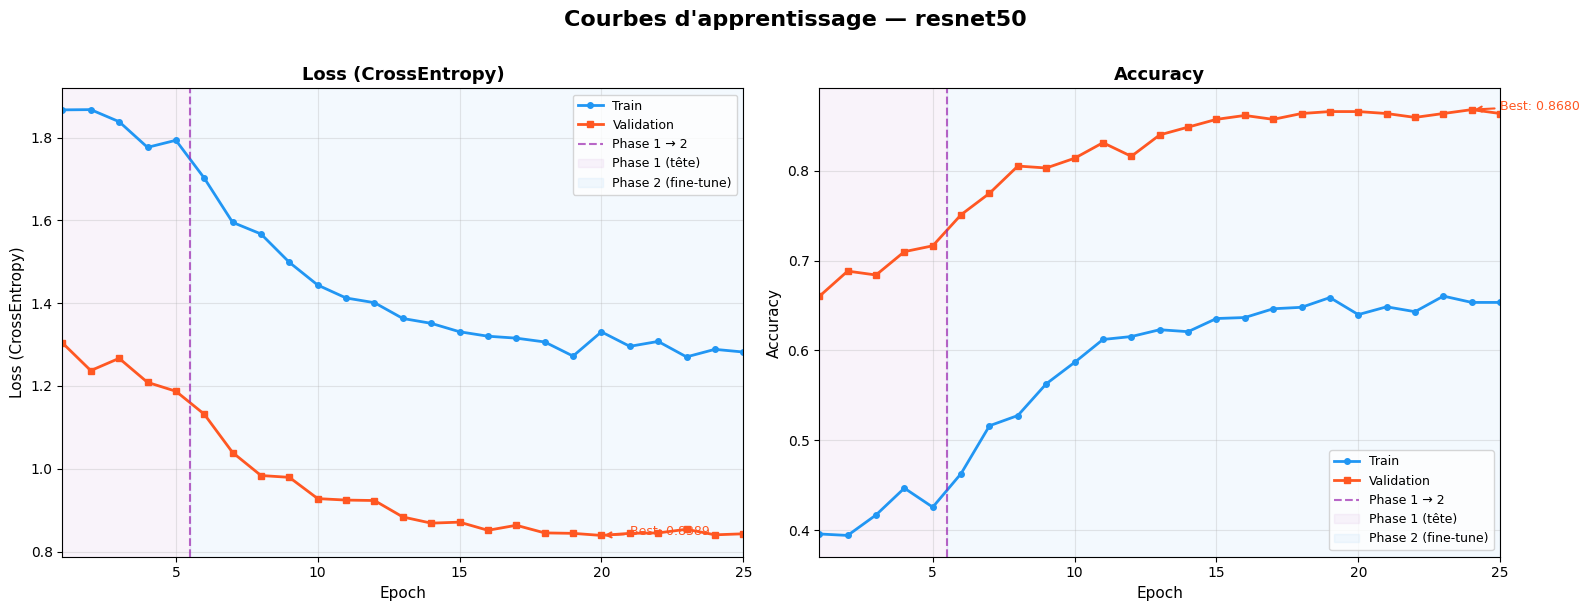

In [ ]:
def plot_learning_curves(history_p1, history_p2, save_path=None):
    """
    Affiche les courbes Loss & Accuracy des 2 phases
    """
    # ── Concatène les 2 phases 
    train_loss = history_p1['train_loss'] + history_p2['train_loss']
    val_loss   = history_p1['val_loss']   + history_p2['val_loss']
    train_acc  = history_p1['train_acc']  + history_p2['train_acc']
    val_acc    = history_p1['val_acc']    + history_p2['val_acc']

    epochs_p1  = len(history_p1['train_loss'])
    epochs_tot = len(train_loss)
    epochs_x   = range(1, epochs_tot + 1)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(
        f"Courbes d'apprentissage — {BACKBONE}",
        fontsize=16, fontweight='bold', y=1.01
    )

    # ── Palette 
    C_TRAIN = '#2196F3'
    C_VAL   = '#FF5722'
    C_SEP   = '#9C27B0'

    for ax, metric, title in zip(
        axes,
        [(train_loss, val_loss), (train_acc, val_acc)],
        ['Loss (CrossEntropy)', 'Accuracy']
    ):
        train_m, val_m = metric

        ax.plot(epochs_x, train_m,
                color=C_TRAIN, linewidth=2,
                marker='o', markersize=4,
                label='Train')
        ax.plot(epochs_x, val_m,
                color=C_VAL, linewidth=2,
                marker='s', markersize=4,
                label='Validation')

        # ── Séparateur Phase 1 / Phase 2 
        ax.axvline(x=epochs_p1 + 0.5,
                   color=C_SEP, linestyle='--',
                   linewidth=1.5, alpha=0.7,
                   label='Phase 1 → 2')

        # ── Annotations zones 
        ax.axvspan(1, epochs_p1 + 0.5,
                   alpha=0.05, color=C_SEP,
                   label='Phase 1 (tête)')
        ax.axvspan(epochs_p1 + 0.5, epochs_tot,
                   alpha=0.05, color=C_TRAIN,
                   label='Phase 2 (fine-tune)')

        # ── Best val 
        best_idx = int(np.argmin(val_m)
                       if 'Loss' in title
                       else np.argmax(val_m))
        best_val = val_m[best_idx]
        ax.annotate(
            f'Best: {best_val:.4f}',
            xy=(best_idx + 1, best_val),
            xytext=(best_idx + 1 + 1, best_val),
            fontsize=9,
            color=C_VAL,
            arrowprops=dict(
                arrowstyle='->', color=C_VAL, lw=1.5
            )
        )
        ax.set_title(title, fontsize=13, fontweight='bold')
        ax.set_xlabel('Epoch', fontsize=11)
        ax.set_ylabel(title, fontsize=11)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(1, epochs_tot)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"💾 Courbes sauvegardées → {save_path}")

    plt.show()

# ── Appel 
plot_learning_curves(
    history_p1,
    history_p2,
    save_path=RESULTS / "learning_curves.png"
)


**Matrice de Confusion & Rapport**

✅ Best model Phase 2 chargé

📊 Val Accuracy  : 0.8680
📊 Val F1 Macro  : 0.8054

────────────────────────────────────────────────────────────
               precision    recall  f1-score   support

       crease     0.7000    0.6364    0.6667        11
 crescent_gap     0.8333    1.0000    0.9091        45
    inclusion     0.7391    0.7907    0.7640        43
     oil_spot     0.8649    0.7805    0.8205        41
punching_hole     0.7959    0.8864    0.8387        44
   rolled_pit     0.4000    0.6667    0.5000         6
    silk_spot     0.9615    0.9615    0.9615       130
waist folding     0.9310    0.9310    0.9310        29
   water_spot     0.9123    0.8966    0.9043        58
 welding_line     0.9000    0.6545    0.7579        55

     accuracy                         0.8680       462
    macro avg     0.8038    0.8204    0.8054       462
 weighted avg     0.8751    0.8680    0.8675       462

────────────────────────────────────────────────────────────

💾 Matrice sauvegardée → 

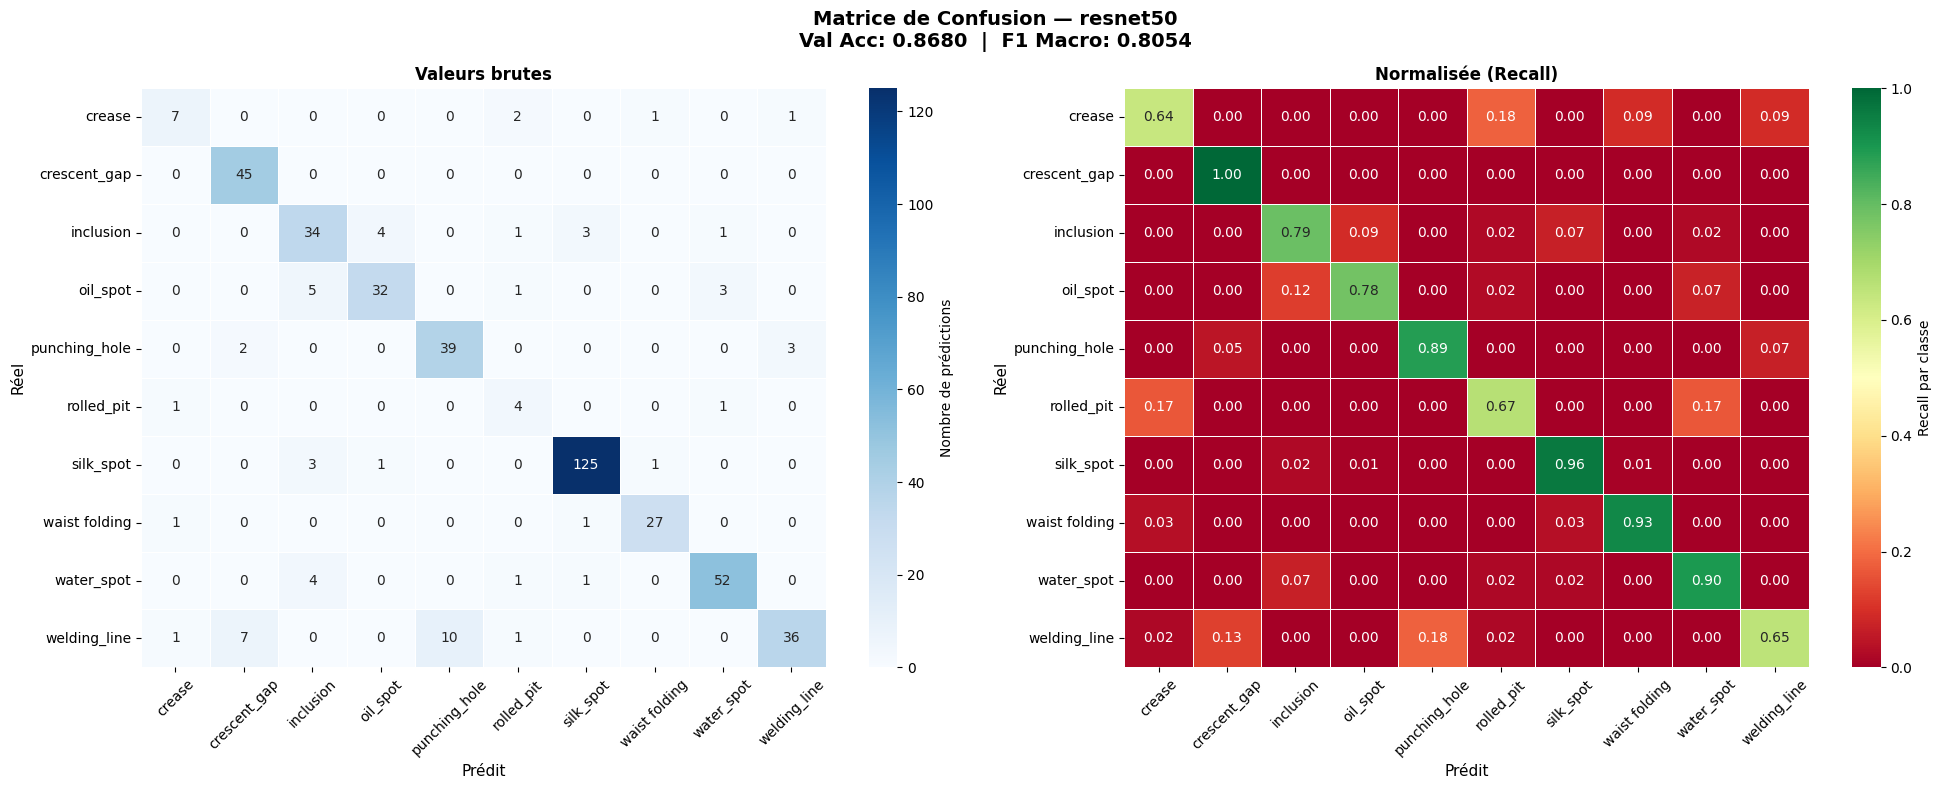


⚠️  Classes avec recall < 0.70 :
────────────────────────────────────────
   crease               recall=0.64  support=  11
   rolled_pit           recall=0.67  support=   6
   welding_line         recall=0.65  support=  55


In [14]:
# ── Charge le meilleur modèle Phase 2 
model.load_state_dict(torch.load(BEST_PATH2))
model.eval()
print(f"✅ Best model Phase 2 chargé")

# ── Inférence complète sur val_loader 
_, val_acc, val_preds, val_targets = eval_one_epoch(
    model, val_loader, criterion
)

val_f1 = f1_score(val_targets, val_preds, average='macro')

print(f"\n📊 Val Accuracy  : {val_acc:.4f}")
print(f"📊 Val F1 Macro  : {val_f1:.4f}\n")

# ── Classification Report 
print("─" * 60)
print(classification_report(
    val_targets,
    val_preds,
    target_names=CLASSES,
    digits=4
))
print("─" * 60)

# ── Matrice de confusion 
cm = confusion_matrix(val_targets, val_preds)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle(
    f"Matrice de Confusion — {BACKBONE}\n"
    f"Val Acc: {val_acc:.4f}  |  F1 Macro: {val_f1:.4f}",
    fontsize=14, fontweight='bold'
)

# ── Plot 1 : valeurs brutes 
sns.heatmap(
    cm,
    annot=True, fmt='d',
    cmap='Blues',
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    ax=axes[0],
    linewidths=0.5,
    cbar_kws={'label': 'Nombre de prédictions'}
)
axes[0].set_title('Valeurs brutes', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Prédit', fontsize=11)
axes[0].set_ylabel('Réel', fontsize=11)
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# ── Plot 2 : normalisée (recall par classe) 
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)

sns.heatmap(
    cm_norm,
    annot=True, fmt='.2f',
    cmap='RdYlGn',
    vmin=0, vmax=1,
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    ax=axes[1],
    linewidths=0.5,
    cbar_kws={'label': 'Recall par classe'}
)
axes[1].set_title('Normalisée (Recall)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Prédit', fontsize=11)
axes[1].set_ylabel('Réel', fontsize=11)
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.savefig(RESULTS / "confusion_matrix.png",
            dpi=150, bbox_inches='tight')
print(f"\n💾 Matrice sauvegardée → {RESULTS}/confusion_matrix.png")
plt.show()

# ── Analyse rapide des classes difficiles 
print("\n⚠️  Classes avec recall < 0.70 :")
print("─" * 40)
for i, cls in enumerate(CLASSES):
    recall = cm_norm[i, i]
    if recall < 0.70:
        support = cm[i].sum()
        print(f"   {cls:<20} recall={recall:.2f}  "
              f"support={support:>4}")


**Export pour Notebook 04**

In [18]:
# ── Sauvegarde modèle final complet 
torch.save({
    "model_state_dict" : model.state_dict(),
    "architecture"     : BACKBONE,
    "num_classes"      : NUM_CLASSES,
    "classes"          : CLASSES,
    "class2idx"        : CLASS2IDX,
    "val_acc"          : val_acc,
    "val_f1"           : val_f1,
    "history_p1"       : history_p1,
    "history_p2"       : history_p2,
    "mean"             : MEAN,
    "std"              : STD,
    "img_size"         : IMG_SIZE,
    "best_path_p1"     : str(BEST_PATH1),
    "best_path_p2"     : str(BEST_PATH2),
}, RESULTS / "final_model.pth")

# ── Résumé des fichiers créés 
files = {
    "best_model_phase1.pth" : RESULTS / "best_model_phase1.pth",
    "best_model_phase2.pth" : RESULTS / "best_model_phase2.pth",
    "final_model.pth"       : RESULTS / "final_model.pth",
    "learning_curves.png"   : RESULTS / "learning_curves.png",
    "confusion_matrix.png"  : RESULTS / "confusion_matrix.png",
}

print("\n╔══════════════════════════════════════════╗")
print("║      ✅ NOTEBOOK 03 TERMINÉ              ║")
print("╠══════════════════════════════════════════╣")
print(f"║  Architecture : {BACKBONE:<25}║")
print(f"║  Val Accuracy : {val_acc:.4f}"
      f"                   ║")
print(f"║  Val F1 Macro : {val_f1:.4f}"
      f"                   ║")
print("╠══════════════════════════════════════════╣")
print("║  Fichiers sauvegardés :                  ║")
for fname, fpath in files.items():
    exists = "✅" if fpath.exists() else "❌"
    size   = (f"{fpath.stat().st_size/1e6:.1f} MB"
              if fpath.exists() else "manquant")
    print(f"║   {exists} {fname:<28}{size:<8}║")
print("╠══════════════════════════════════════════╣")
print("║  → Prêt pour Notebook 04 : Analyse       ║")
print("╚══════════════════════════════════════════╝")


╔══════════════════════════════════════════╗
║      ✅ NOTEBOOK 03 TERMINÉ              ║
╠══════════════════════════════════════════╣
║  Architecture : resnet50                 ║
║  Val Accuracy : 0.8680                   ║
║  Val F1 Macro : 0.8054                   ║
╠══════════════════════════════════════════╣
║  Fichiers sauvegardés :                  ║
║   ✅ best_model_phase1.pth       98.6 MB ║
║   ✅ best_model_phase2.pth       98.6 MB ║
║   ✅ final_model.pth             98.6 MB ║
║   ✅ learning_curves.png         0.1 MB  ║
║   ✅ confusion_matrix.png        0.2 MB  ║
╠══════════════════════════════════════════╣
║  → Prêt pour Notebook 04 : Analyse       ║
╚══════════════════════════════════════════╝
